In [65]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [66]:
glove_path = "/content/drive/My Drive/Fake news classifier/glove.6B.100d.txt"
train_path = "/content/drive/My Drive/Fake news classifier/train.csv"
test_path = "/content/drive/My Drive/Fake news classifier/test.csv"

In [67]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [68]:
print(df_train.shape)
print(df_test.shape)

(20800, 5)
(5200, 4)


In [69]:
df_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [70]:
def drop_missing(df):
  df.dropna(how = 'any', inplace=True)
  df.reset_index(drop = True, inplace=True)
  return df

def drop_cols(df):
    if('id' in df.columns):
      df.drop(['id', 'author'], axis = 1, inplace=True) 
    return df

In [71]:
df_train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [72]:
df_train = drop_missing(df_train)
df_train = drop_cols(df_train)
print(df_train.shape)

(18285, 3)


In [73]:
def basic_cleaning(df):
  df = df.apply(lambda x: x.astype(str).str.lower()) #apply to all rows, lambda is a temporary function
  df = df.apply(lambda x: x.astype(str).str.replace('\n', ""))#remove linebreaks
  return df

In [74]:
df_train = basic_cleaning(df_train)
df_test = basic_cleaning(df_test)
display(df_train)
display(df_test)

,title,text,label
0,house dem aide: we didn’t even see comey’s let...,house dem aide: we didn’t even see comey’s let...,1
1,"flynn: hillary clinton, big woman on campus - ...",ever get the feeling your life circles the rou...,0
2,why the truth might get you fired,"why the truth might get you fired october 29, ...",1
3,15 civilians killed in single us airstrike hav...,videos 15 civilians killed in single us airstr...,1
4,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to s...,1
...,...,...,...
18280,rapper t.i.: trump a ’poster child for white s...,rapper t. i. unloaded on black celebrities who...,0
18281,"n.f.l. playoffs: schedule, matchups and odds -...",when the green bay packers lost to the washing...,0
18282,macy’s is said to receive takeover approach by...,the macy’s of today grew from the union of sev...,0
18283,"nato, russia to hold parallel exercises in bal...","nato, russia to hold parallel exercises in bal...",1


,id,title,author,text
0,20800,"specter of trump loosens tongues, if not purse...",david streitfeld,"palo alto, calif. — after years of scorning..."
1,20801,russian warships ready to strike terrorists ne...,nan,russian warships ready to strike terrorists ne...
2,20802,#nodapl: native american leaders vow to stay a...,common dreams,videos #nodapl: native american leaders vow to...
3,20803,"tim tebow will attempt another comeback, this ...",daniel victor,"if at first you don’t succeed, try a different..."
4,20804,keiser report: meme wars (e995),truth broadcast network,42 mins ago 1 views 0 comments 0 likes 'for th...
...,...,...,...,...
5195,25995,the bangladeshi traffic jam that never ends - ...,jody rosen,of all the dysfunctions that plague the world’...
5196,25996,john kasich signs one abortion bill in ohio bu...,sheryl gay stolberg,washington — gov. john kasich of ohio on tu...
5197,25997,"california today: what, exactly, is in your su...",mike mcphate,good morning. (want to get california today by...
5198,25998,300 us marines to be deployed to russian borde...,nan,« previous - next » 300 us marines to be deplo...


In [75]:
def extensive_cleaning(df):
  #cleaning done using regular expressions
  df = df.apply(lambda x: x.astype(str).str.replace(r'http[\w:/\.]+','URL'))
  #urls beginning wiht http followed by any word character set (\w) or (:) or (.) or (%20)
  df = df.apply(lambda x: x.astype(str).str.replace(r'(\S)+\.com((\S)+)?','URL')) 
  df = df.apply(lambda x: x.astype(str).str.replace(r'[^\.\w\s]','')) #remove everything but characters and punctuation
  df = df.apply(lambda x: x.astype(str).str.replace(r'\.','.')) #replace multiple periods with a single one
  df = df.apply(lambda x: x.astype(str).str.replace(r'\s\s+',' ')) #replace multiple white space with a single one
  return df

In [76]:
df_train = extensive_cleaning(df_train)
df_test = extensive_cleaning(df_test)

In [77]:
train_labels = df_train['label'].astype('int').to_numpy()
train_title = df_train['title']
test_title = df_test['title']
display(train_labels.shape)

(18285,)

In [78]:
def lemmatize(X):
  corpus = []
  for i in range(len(X)):
      news = X[i]
      news = news.split()
      news = [lemmatizer.lemmatize(word) for word in news if not word in stopwords.words('english')]
      news = ' '.join(news)
      corpus.append(news)
  return corpus

In [79]:
train_corpus = lemmatize(train_title)
test_corpus = lemmatize(test_title)

In [88]:
word2glove = {}
glove_words = []
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        #values are in list of string format so convert to vector
        vector = np.asarray(values[1:], "float32")
        word2glove[word] = vector
        glove_words.append(word)
EMBEDDING_DIM = len(vector)

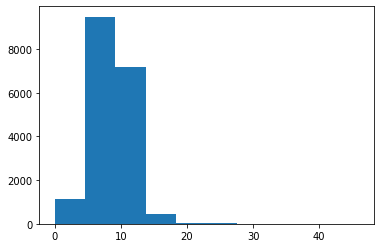

The number of news greater than MAX_NEWS_LENGTH in length is:  0
The number of news less than MAX_NEWS_LENGTH in length is:  0
20408
4044
16735
73
3673
16810
82.00215601724814


In [81]:
corpus = train_corpus
#PREPARE GLOVE DICTIONARY FOR ENCODING NEWS--->
all_text = ' '.join(corpus)
from collections import Counter
words = all_text.split()
corpus_u_words_counter = Counter(words).most_common() #tuple of unique words, frequency
corpus_u_words_frequent = [word[0] for word in corpus_u_words_counter if word[1]>5] #keep only words which have occured more than 5 times for deciding about words not in glove later
corpus_u_words = [word for word, count in corpus_u_words_counter]

glove_words_index = dict(zip(glove_words, range(len(glove_words))))

#filter corpus words --> words in glove / not in glove.. use a boolean array to reduce comparisons
#glove_word_index is a hash table --> quick search
is_corpus_word_in_glove = np.array([w in glove_words_index for w in corpus_u_words])
words_in_glove = [word for word, is_true in zip(corpus_u_words, is_corpus_word_in_glove)  if is_true]
words_not_in_glove = [word for word, is_true in zip(corpus_u_words, is_corpus_word_in_glove)  if not is_true]
freq_words_not_in_glove = [w for w in words_not_in_glove if w in corpus_u_words_frequent]

# create the dictionary of glove weights
word2index = dict(zip(words_in_glove, range(len(words_in_glove)))) #we have weights for this! --> fixed
freq_words_not_in_glove_index = dict(zip(freq_words_not_in_glove, range(len(word2index), len(word2index)+len(freq_words_not_in_glove)))) #we have to learn weights for this --> train embedding
word2index = dict(**word2index, **freq_words_not_in_glove_index) 
word2index['<Other>'] = len(word2index) #all others are accounted as other tag and one common embedding is learnt --> train embedding

#histogram of title word length
plt.hist([len(t.split()) for t in corpus])
plt.show()
MAX_NEWS_LENGTH = 25

print('The number of news greater than MAX_NEWS_LENGTH in length is: ', np.sum(np.array([len(news)> MAX_NEWS_LENGTH for news in encoded_news])))
print('The number of news less than MAX_NEWS_LENGTH in length is: ', np.sum(np.array([len(news)< MAX_NEWS_LENGTH for news in encoded_news])))

#PADDING

word2index['<PAD>'] = len(word2index)


print(len(corpus_u_words))
print(len(corpus_u_words_frequent))
print(len(words_in_glove))
print(len(freq_words_not_in_glove))
print(len(words_not_in_glove))
print(len(word2index))
print(100*len(words_in_glove)/len(corpus_u_words))

In [82]:
def encode_news(corpus):
  encoded_news = []
  for news in corpus:
    int_news = [word2index[word] if word in word2index else word2index['<Other>'] for word in news.split()] 
    encoded_news.append(int_news)
  return encoded_news

In [83]:
encoded_train_news = encode_news(train_corpus)
encoded_test_news = encode_news(test_corpus)

In [84]:
def pad_news(encoded_news):
  for i, news in zip(range(len(encoded_news)), encoded_news):
    if (len(news) < MAX_NEWS_LENGTH):
      encoded_news[i] = [word2index['<PAD>']]*(MAX_NEWS_LENGTH - len(news)) + news
    elif (len(news) > MAX_NEWS_LENGTH):
      encoded_news[i] = news[:MAX_NEWS_LENGTH]
    else:
      continue
  return encoded_news

In [85]:
encoded_train_news = pad_news(encoded_train_news)
encoded_test_news = pad_news(encoded_test_news)

In [86]:
train_input = np.array(encoded_train_news)
train_label = train_labels.reshape(-1, 1)
test_input = np.array(encoded_test_news)

In [87]:
print(train_input.shape)
print(train_label.shape)

(18285, 25)
(18285, 1)


In [100]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers
import numpy as np

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)

In [101]:
#basic method
model = Sequential()
model.add(Embedding2(len(word2index) + 1, EMBEDDING_DIM,
                    fixed_weights=np.array([word2glove[w] for w in words_in_glove]))) 
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(MAX_NEWS_LENGTH)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
batch_size = 128
epochs = 5

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2 (Embedding2)      (None, None, 100)         1681100   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                25200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,706,351
Trainable params: 32,851
Non-trainable params: 1,673,500
_________________________________________________________________


In [102]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_label, test_size=0.3, random_state=42)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/5
100/100 [==============================] - 4s 45ms/step - loss: 0.4018 - accuracy: 0.8324 - val_loss: 0.2758 - val_accuracy: 0.8870
Epoch 2/5
100/100 [==============================] - 4s 36ms/step - loss: 0.2654 - accuracy: 0.8895 - val_loss: 0.2502 - val_accuracy: 0.8952
Epoch 3/5
100/100 [==============================] - 4s 36ms/step - loss: 0.2385 - accuracy: 0.8992 - val_loss: 0.2459 - val_accuracy: 0.8985
Epoch 4/5
100/100 [==============================] - 4s 36ms/step - loss: 0.2216 - accuracy: 0.9091 - val_loss: 0.2272 - val_accuracy: 0.8999
Epoch 5/5
100/100 [==============================] - 4s 36ms/step - loss: 0.2098 - accuracy: 0.9115 - val_loss: 0.2106 - val_accuracy: 0.9058


In [92]:
test_id = df_test['id']

In [93]:
df_test = drop_cols(df_test)

In [94]:
df_test.isnull().sum()

title    0
text     0
dtype: int64

In [96]:
test_input.shape

(5200, 25)

In [105]:
predictions = model.predict_classes(test_input)

In [119]:
predictions


array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [107]:
df_test['preds'] = predictions

In [108]:
df_test

,title,text,preds
0,specter of trump loosens tongues if not purse ...,palo alto calif. after years of scorning the p...,0
1,russian warships ready to strike terrorists ne...,russian warships ready to strike terrorists ne...,1
2,nodapl native american leaders vow to stay all...,videos nodapl native american leaders vow to s...,1
3,tim tebow will attempt another comeback this t...,if at first you dont succeed try a different s...,0
4,keiser report meme wars e995,42 mins ago 1 views 0 comments 0 likes for the...,1
...,...,...,...
5195,the bangladeshi traffic jam that never ends th...,of all the dysfunctions that plague the worlds...,0
5196,john kasich signs one abortion bill in ohio bu...,washington gov. john kasich of ohio on tuesday...,0
5197,california today what exactly is in your sushi...,good morning. want to get california today by ...,0
5198,300 us marines to be deployed to russian borde...,previous next 300 us marines to be deployed t...,1


In [118]:
submission = pd.DataFrame({'id':test_id, 'label':predictions.flatten()})
submission.shape

(5200, 2)

In [121]:
submission.to_csv('submission.csv',index=False)
